In [2]:
'''
Loads data, trains som.py
'''
import sys
from sklearn.linear_model import LogisticRegression
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import matplotlib
import json

def lookup(num):
    var_list = ['Bearing-In-Vib', 'Bearing-Out-Vib', 'Motor-In-Vib', 'Motor-Out-Vib']
    if num < 8: var = var_list[0]
    elif (num > 8) and (num < 16): var = var_list[1]
    elif (num > 16) and (num < 24): var = var_list[2]
    else: var = var_list[3]
        
    num = num % 8
    name_lookup = {'0': 'pk-to-pk', '1': 'rms', '2': 'kurtosis', '3': 'skew', '4': 'standard-deviation'}
    #name_lookup = {'0': 'entropy', '1': 'no-peaks', '2': 'highest-autocorr', '3': 'skew', '4': 'standard-deviation'}
    name_lookup = {k: v + '-' + var for (k, v) in name_lookup.items()}
    
    n=0
    for name in var_list:
        if name != var:
            name_lookup.update({str(n+5):'corr-' + var + '-' + name})
            n+=1
            
    return name_lookup[str(num)]

def get_training_data():
    train = np.loadtxt('../data/training-data-som.csv', delimiter = ',')
    df1 = np.loadtxt("../data/testing-data-som.csv", delimiter = ',')
    df2 = np.loadtxt("../data/testingtwo-data-som.csv", delimiter = ',')
    df3 = np.loadtxt("../data/testingthree-data-som.csv", delimiter = ',')
    df4 = np.loadtxt("../data/testingfour-data-som.csv", delimiter = ',')
    df5 = np.loadtxt("../data/testingfive-data-som.csv", delimiter = ',')
    df_failure = np.loadtxt("../data/failure-data-som.csv", delimiter = ',')
    return train, df1, df2, df3, df4, df5, df_failure

def get_training_data_north():
    train = np.loadtxt('../data/training-north-data-som.csv', delimiter = ',')
    df1 = np.loadtxt("../data/testing-north-data-som.csv", delimiter = ',')
    df2 = np.loadtxt("../data/testingtwo-north-data-som.csv", delimiter = ',')
    df3 = np.loadtxt("../data/testingthree-north-data-som.csv", delimiter = ',')
    df_failure = np.loadtxt("../data/failure-north-data-som.csv", delimiter = ',')
    return train, df1, df2, df3, df_failure

def create_label(a, val):
    s = a.shape[0]
    if val == 0: b = np.zeros(s)
    else: b = np.ones(s)
    return b


In [3]:

feb7, jan1, jan16, jan7, jan3, jan5, failure = get_training_data()
#ntrain, ndf1, ndf2, ndf3, ndf_failure = get_training_data_north()

feb7.shape

(925, 32)

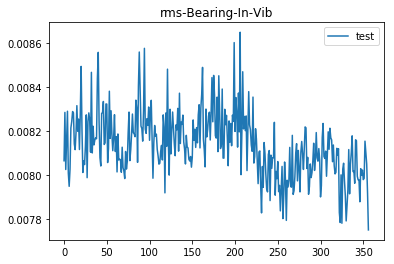

In [4]:
import matplotlib.pyplot as plt
i=1
#plt.plot(failure[:,i], label = 'failure')
plt.plot(jan5[:,i], label = 'test')
plt.legend()
plt.title(lookup(i))
plt.show()

In [5]:
label_feb7=create_label(feb7, 0)    
label_jan16=create_label(jan16, 0)    
label_failure=create_label(failure, 1)    

In [6]:
train = np.concatenate((feb7, jan16, failure))
labels = np.concatenate((label_feb7, label_jan16, label_failure))
train.shape
labels.shape

(2138,)

In [7]:
from sklearn.decomposition import PCA
pca = PCA(n_components=10)
train = pca.fit_transform(train)

In [8]:
clf = LogisticRegression(random_state=0, solver='lbfgs', n_jobs=-1)
clf.fit(train, labels)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn', n_jobs=-1,
          penalty='l2', random_state=0, solver='lbfgs', tol=0.0001,
          verbose=0, warm_start=False)

In [12]:
def mov_avg(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

feb 7th
0.9978378378378379


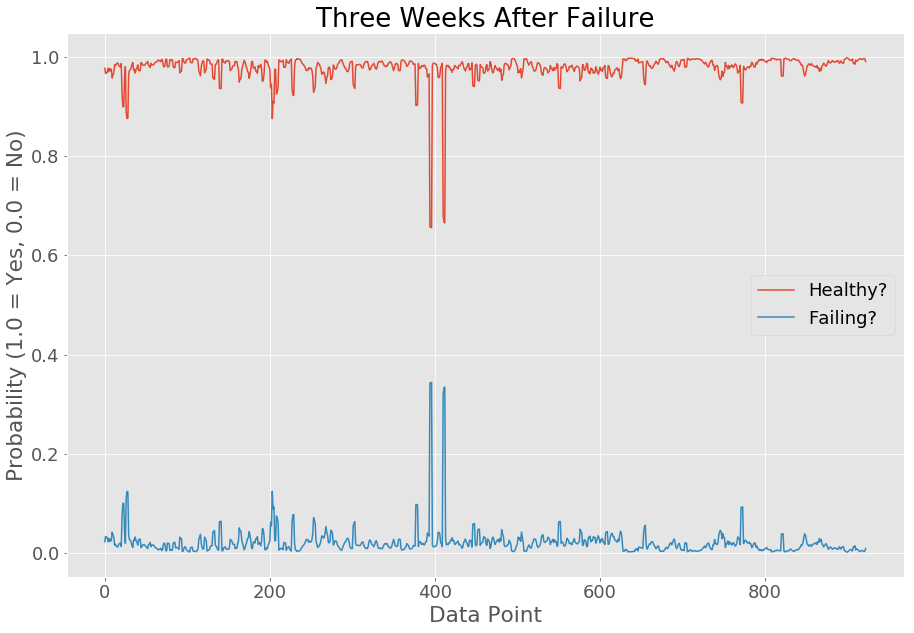

failure
0.9189814814814815


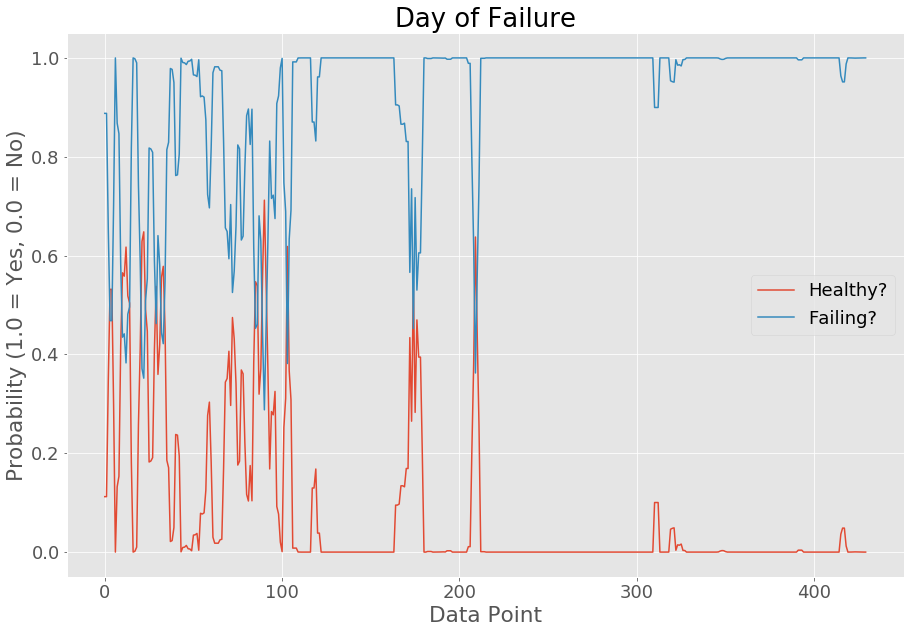

jan 16th
0.9948783610755442


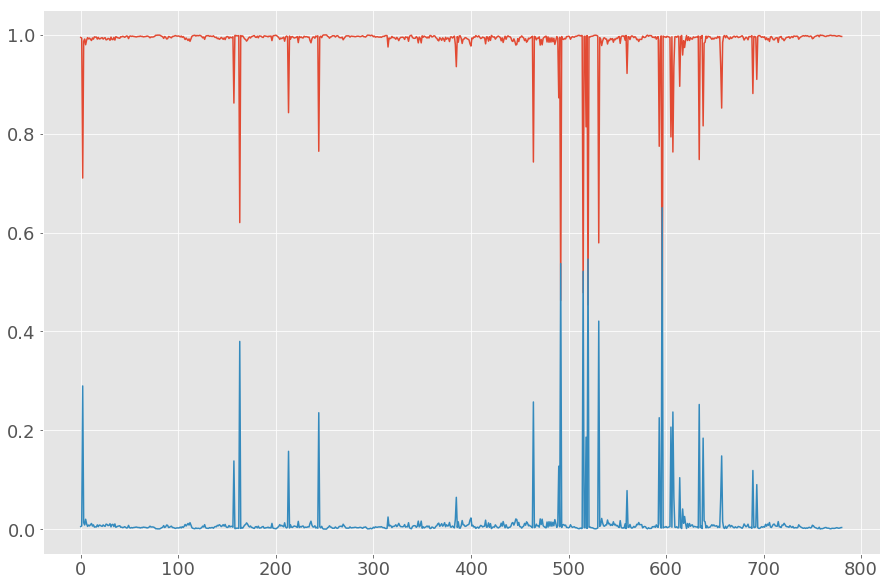

test jan 1st


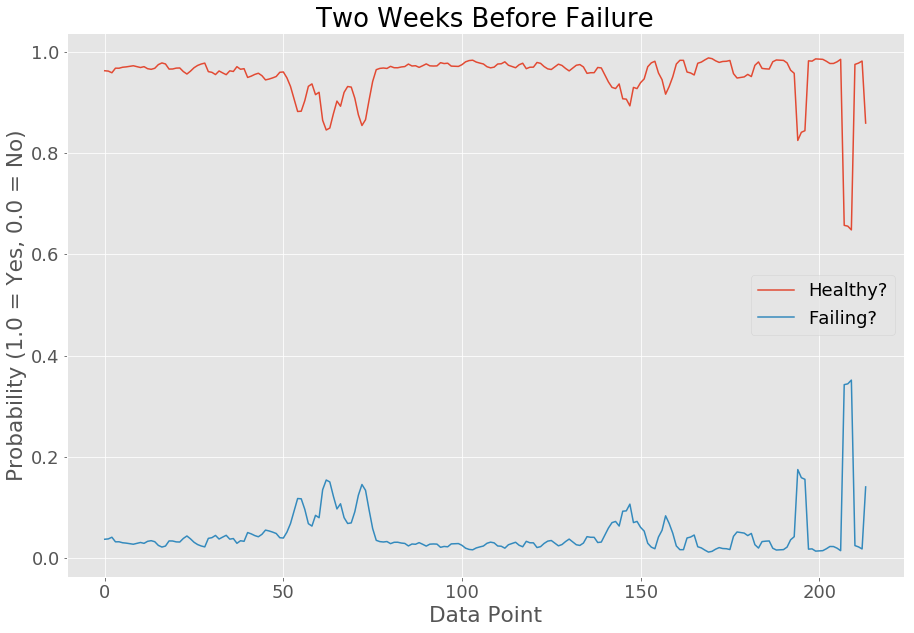

test jan 7th


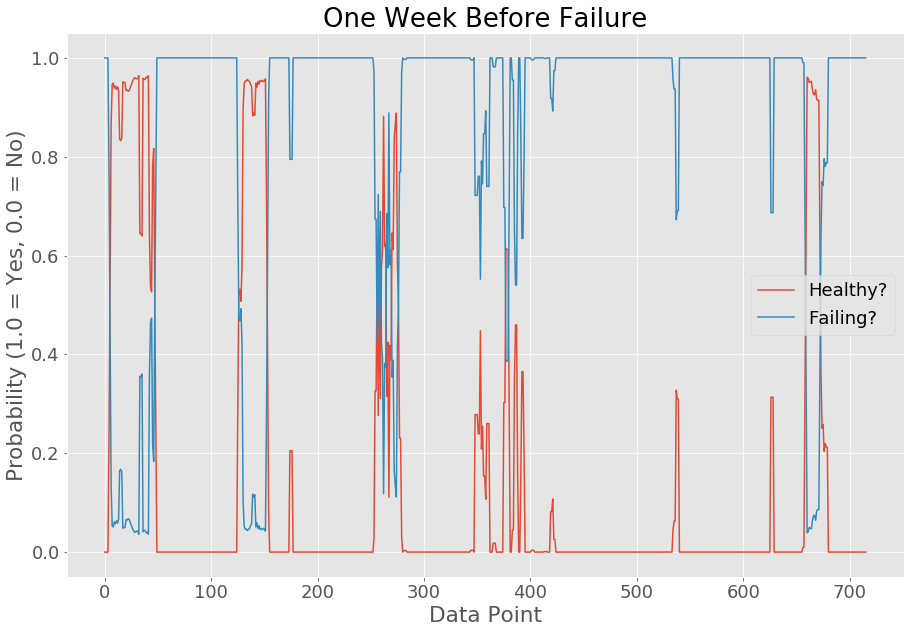

test jan 3rd


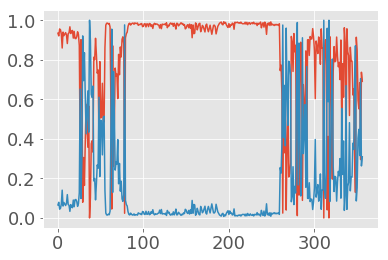

test jan 5th


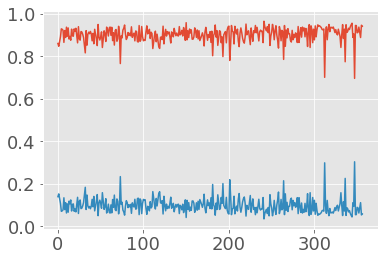

In [16]:
plt.style.use('ggplot')
plt.rcParams.update({'font.size': 18})

test = pca.transform(feb7)
pred = clf.predict_proba(test)
print("feb 7th")
print(clf.score(test, label_feb7))
plt.figure(figsize=(15,10))
plt.plot(mov_avg(pred[:,0]), label = 'Healthy?')
plt.plot(mov_avg(pred[:,1]), label = 'Failing?')
plt.title('Three Weeks After Failure')
plt.legend()
plt.ylabel("Probability (1.0 = Yes, 0.0 = No)")
plt.xlabel("Data Point")
plt.savefig('../figs/log-feb7.png')
plt.show()


test = pca.transform(failure)
pred = clf.predict_proba(test)
print("failure")
print(clf.score(test, label_failure))
plt.figure(figsize=(15,10))
plt.plot(mov_avg(pred[:,0]), label = 'Healthy?')
plt.plot(mov_avg(pred[:,1]), label = 'Failing?')
plt.title('Day of Failure')
plt.legend()
plt.ylabel("Probability (1.0 = Yes, 0.0 = No)")
plt.xlabel("Data Point")
plt.savefig('../figs/log-fail.png')
plt.show()

test = pca.transform(jan16)
pred = clf.predict_proba(test)
print("jan 16th")
print(clf.score(test, label_jan16))
plt.figure(figsize=(15,10))
plt.plot(pred)
plt.show()

test = pca.transform(jan1)
pred = clf.predict_proba(test)
print("test jan 1st")
plt.figure(figsize=(15,10))
plt.plot(mov_avg(pred[:,0]), label = 'Healthy?')
plt.plot(mov_avg(pred[:,1]), label = 'Failing?')
plt.title('Two Weeks Before Failure')
plt.legend()
plt.ylabel("Probability (1.0 = Yes, 0.0 = No)")
plt.xlabel("Data Point")
plt.savefig('../figs/log-jan1.png')
plt.show()

test = pca.transform(jan7)
pred = clf.predict_proba(test)
print("test jan 7th")
plt.figure(figsize=(15,10))
plt.plot(mov_avg(pred[:,0]), label = 'Healthy?')
plt.plot(mov_avg(pred[:,1]), label = 'Failing?')
plt.title('One Week Before Failure')
plt.legend()
plt.ylabel("Probability (1.0 = Yes, 0.0 = No)")
plt.xlabel("Data Point")
plt.savefig('../figs/log-jan7.png')
plt.show()

test = pca.transform(jan3)
pred = clf.predict_proba(test)
print("test jan 3rd")
plt.plot(pred)
plt.show()

test = pca.transform(jan5)
pred = clf.predict_proba(test)
print("test jan 5th")
plt.plot(pred)
plt.show()